In [271]:
# some ideas just for curiosity:
# - could train an RL model to predict what dominoes are in other agents hands based on what has been played, their line, and what is available...
# - for hand-crafted networks, I wonder if graph theory methods can speed up the line-value estimation methods...

In [156]:
%reload_ext autoreload
%autoreload 2

from copy import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import dominoesGameplay as dg
import dominoesAgents as da
import dominoesNetworks as dn
import dominoesFunctions as df
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [272]:
# Code Reorganization:
# - follow the DRY principle!
# - think carefully about all the steps of running a game and make sure this is efficient
# - create a smarter system for managing agents so it's easy to pass learned network parameters to each agent

# Modified Agent Idea: 
# - I also think I should also create a line value agent that can learn how to modify the ancillary parameters -- e.g. the discounting and temperature parameters. 

# Specific Updates to Value Agents --
# - I don't think I need to estimate pre/post states every play. This will save so much computation time, and may even be easier for the agents to learn. 
# - However, there needs to be an additional function run at the end of each game that provides reward feedback for the final TD-Lambda step at the end of the game.


# I think after checking that not estimating pre/post states every play works, I can start my blog post!!!
# 1. Creating a system that plays dominoes
# 2. Hand-crafted agents that play with specific rules
# 3. Finding a way to represent the game-state in a way that can be fed to a neural network
#    3.1 -- Simple networks can't learn how to do addition and biased subtraction...?
# 4. Adding information to the game-state about possible line sequences for the network to use more information in deciding how to play
# 5. Building a neural network that can outperform the line value networks without hand-crafted information (e.g. a Transformer)

In [165]:
numPlayers = 4
highestDominoe = 9
numRounds = 1000
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers,  agents=(da.bestLineAgent, da.doubleAgent, da.greedyAgent, da.stupidAgent), device=device)
game.playGame(rounds=numRounds,withUpdates=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.92it/s]


In [166]:
print(game.currentWinner)
print(game.currentScore / numRounds)

0
[ 7.297  9.658 12.239 26.239]


In [158]:
# print performance monitoring
print(game.initHandTime[0]/game.initHandTime[1])
print(game.presentGameStateTime[0]/game.presentGameStateTime[1])
print(game.agentPlayTime[0]/game.agentPlayTime[1])
print(game.processPlayTime[0]/game.processPlayTime[1])

7.429575920104981e-05
1.3712866938471637e-05
3.413980128097773e-05
9.372700797585069e-06


In [ ]:
# I'm pretty sure TD-Lambda is working now. So:
# Start by loading up some agents, then run many many rounds
# Let's use 1 value agent and 3 default agents
# After many rounds (with learning), run a few more and measure performance. 

# initialize game, and create agents
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGameValueAgents(highestDominoe, numPlayers=numPlayers, agents=(da.lineValueAgent, da.bestLineAgent, da.lineValueAgent, da.bestLineAgent), defaultAgent=da.dominoeAgent, device=device)

# run training rounds
trainingGames = 100
trainingRounds = 50
trainingWinnerCount = np.zeros(numPlayers)
trainingScoreTally = np.zeros((trainingGames,numPlayers))
for gameIdx in tqdm(range(trainingGames)):
    game.playGame(rounds=trainingRounds)
    trainingWinnerCount[game.currentWinner] += 1
    trainingScoreTally[gameIdx] += game.currentScore

# measure performance
performanceGames = 10
performanceRounds = 50
performanceWinnerCount = np.zeros(numPlayers)
performanceScoreTally = np.zeros(numPlayers)
for _ in tqdm(range(performanceGames)):
    game.playGame(rounds=performanceRounds)
    performanceWinnerCount[game.currentWinner] += 1 
    performanceScoreTally += game.currentScore


  6%|████▊                                                                           | 6/100 [08:33<2:15:03, 86.21s/it]

Games won: [0. 1. 7. 2.]
Expected score per hand: [13.49  12.222  9.112 11.616]


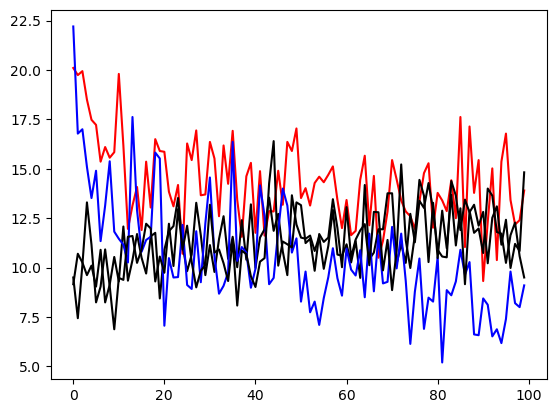

In [273]:
print(f"Games won: {performanceWinnerCount}")
print(f"Expected score per hand: {performanceScoreTally / performanceGames / performanceRounds}")
c = ['r','k','b','k']
for i in range(4):
    plt.plot(range(trainingGames), trainingScoreTally[:,i]/trainingRounds, c=c[i])

In [248]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGameValueAgents(highestDominoe, numPlayers=numPlayers,  defaultAgent=da.valueAgent0, device=device)
# game = dg.dominoeGameValueAgents(highestDominoe, numPlayers=numPlayers,  agents=(da.lineValueAgent, da.doubleAgent, da.greedyAgent, da.stupidAgent), device=device)
game.initializeHand()

In [121]:
# test some variants of the best line agent against other agents
numPlayers = 6
highestDominoe = 12

# agents = (da.stupidAgent, da.bestLineAgent, da.greedyAgent, da.doubleAgent, da.bestLineAgent, da.dominoeAgent)
agents = (None, da.bestLineAgent, None, None, da.bestLineAgent, None)
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, agents=agents, defaultAgent=da.dominoeAgent)
game.agents[1].inLineDiscount = 0.45
game.agents[1].offLineDiscount = 0.7
game.agents[4].inLineDiscount = 0.9
game.agents[4].offLineDiscount = 0.7

# measure performance
numGames = 100
numRounds = highestDominoe+1
winnerCount = np.zeros(numPlayers)
scoreTally = np.zeros(numPlayers)
for _ in tqdm(range(numGames)):
    game.playGame(rounds=numRounds)
    winnerCount[game.currentWinner] += 1 
    scoreTally += game.currentScore
print(np.round(1000*winnerCount/numGames)/1000)
print(np.round(10*scoreTally / numRounds / numGames)/10)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]

[0.  0.4 0.  0.  0.6 0. ]
[27.2 11.1 27.1 27.7 10.4 28.4]


## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [159]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playGame()
game.printResults()

[[  0  25  57  20]
 [130  97 129 123]
 [136 104 106 135]
 [118 118 140 107]
 [ 83 136 124 142]
 [127 127 113 120]
 [133 114 120 122]
 [119 151 134  87]
 [122 132 116 123]
 [119 110 133 133]]
[1087 1114 1172 1112]
The winner is agent: 0 with a score of 1087!


In [153]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|7 ', ' 7|5 ', ' 5|5 ', ' 5|4 ', ' 4|0 ', ' 0|0 ']
[' 9|5 ', ' 5|6 ', ' 6|7 ', ' 7|8 ', ' 8|4 ', ' 4|7 ', ' 7|3 ', ' 3|8 ', ' 8|2 ', ' 2|4 ']
[' 9|8 ', ' 8|0 ', ' 0|7 ', ' 7|1 ', ' 1|1 ', ' 1|5 ', ' 5|3 ', ' 3|2 ']
[' 9|2 ', ' 2|6 ', ' 6|3 ', ' 3|0 ', ' 0|5 ', ' 5|8 ', ' 8|1 ']
[' 9|6 ', ' 6|0 ', ' 0|9 ', ' 9|3 ', ' 3|3 ', ' 3|4 ', ' 4|4 ', ' 4|6 ', ' 6|6 ', ' 6|1 ', ' 1|4 ', ' 4|9 ', ' 9|1 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


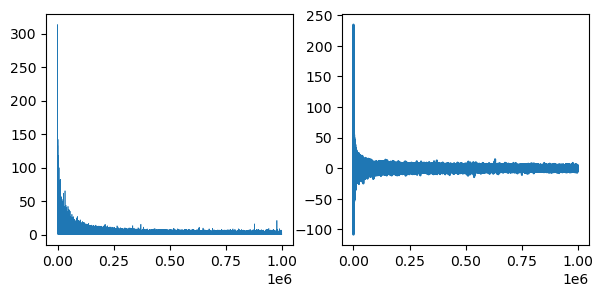

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()